In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/home/by256/Documents/Projects/imagedataextractor')
# import imagedataextractor
import imagedataextractor as ide
# import other things
import cv2
import copy
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


In [3]:
im_path = './example-image.png'
device = 'cpu'

data = ide.extract(im_path, 
                   seg_bayesian=True,  # Bayesian mode
                   seg_tu=0.0125,  # uncertainty threshold beyond which to filter FPs
                   seg_n_samples=50,  # number of monte carlo samples for Bayesian inference
                   seg_device='cpu'  # set to 'cuda' to utilise GPU.
                  )[0]  # take first value since we are extracting a single image.

In [4]:
image = cv2.imread(im_path)

In [5]:
# segmentation

seg = data.segmentation.astype(float)
# from imagedataextractor.utils import shuffle_segmap
# seg = shuffle_segmap(seg)
seg[seg == 0] = np.nan  # for visualization purposes
uncertainty = data.uncertainty

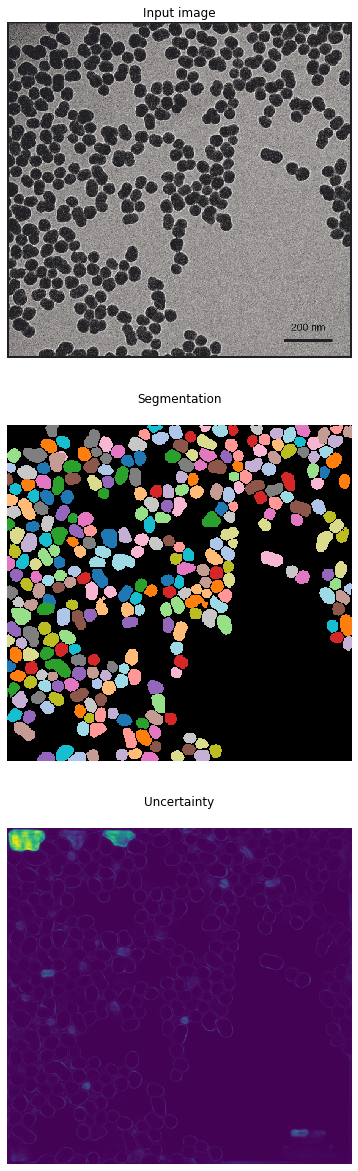

In [6]:
# visualize segmentation an uncertainty

seg_cmap = copy.copy(matplotlib.cm.tab20)
seg_cmap.set_bad(color='k')

fig, axes = plt.subplots(3, 1, figsize=(7, 21))
for ax in axes:
    ax.axis('off')
axes[0].set_title('Input image')
axes[0].imshow(image)
axes[1].set_title('Segmentation')
axes[1].matshow(seg, cmap=seg_cmap)
axes[2].set_title('Uncertainty')
axes[2].matshow(uncertainty)
plt.show()

#### Scalebar

Let's look at the scalebar extraction results.

In [7]:
# scalebar conversion

sb_text = data.scalebar.text
conversion = data.scalebar.conversion

sb_text, conversion

('200 nm', 1.5584415584415584e-09)

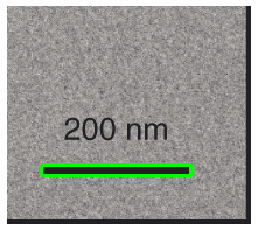

In [8]:
sb_image = cv2.drawContours(image, [data.scalebar.scalebar_contour], 0, (0, 255, 0), 2)

plt.imshow(sb_image[700:, 700:])
plt.axis('off')
plt.show()

It looks like the scalebar was read and measured correctly.

#### Extracted Data

Let's view the data as a pandas `DataFrame`.

In [9]:
df = data.to_pandas()
df.head()

,idx,center,edge,contours,area (pixels^2),area,area_units,aspect_ratio,shape_estimate,diameter,diameter_units,original_units,uncertainty
0,1,"[636, 9]",True,"[[[[ 0 618]], [[ 0 652]], [[ 10 652]], [[ 10...",581,1.411098e-15,meters^2,0.657143,None,NaN,meters,nm,0.004770
1,2,"[297, 270]",False,"[[[[257 274]], [[256 275]], [[256 276]], [[255...",1835,4.456738e-15,meters^2,0.846154,None,NaN,meters,nm,0.004772
2,3,"[189, 158]",False,"[[[[154 172]], [[153 173]], [[151 173]], [[151...",998,2.423883e-15,meters^2,0.947368,circle,5.555343e-08,meters,nm,0.004771
3,4,"[220, 564]",False,"[[[[563 203]], [[562 204]], [[557 204]], [[557...",851,2.066858e-15,meters^2,0.888889,circle,5.129917e-08,meters,nm,0.004771
4,5,"[408, 422]",False,"[[[[423 393]], [[423 394]], [[422 395]], [[415...",834,2.025569e-15,meters^2,1.129032,circle,5.078420e-08,meters,nm,0.004771


#### Particle Sizes

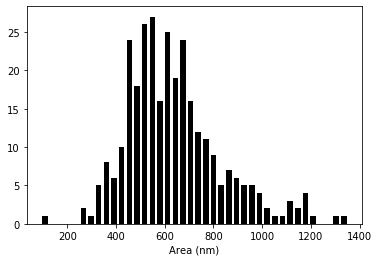

In [10]:
sizes = df['area (pixels^2)'].to_numpy() # These are in units of pixels^2.

# Let's use our scalebar conversion to convert to nanometers.
sizes = sizes / conversion  # to meters
sizes = sizes * 1e-9  # to nanometers

plt.hist(sizes, bins=40, color='k', rwidth=0.7)
plt.xlabel('Area (nm)')
plt.show()

In [11]:
print('Average particle size: {:.3f} nm    std deviation: {:.3f} nm'.format(np.mean(sizes), np.std(sizes)))

Average particle size: 637.423 nm    std deviation: 195.456 nm


#### Particle Coordinates

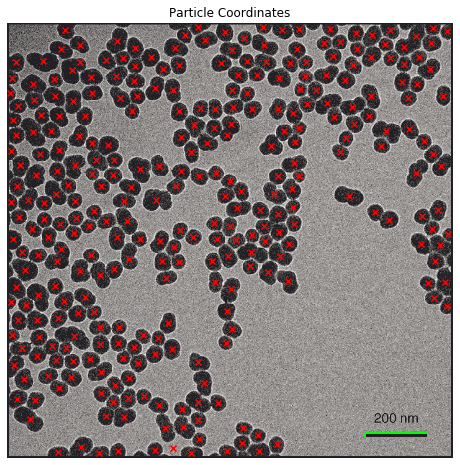

In [12]:
coords = data.coords

plt.figure(figsize=(8, 8))
plt.title('Particle Coordinates')
plt.imshow(image)
plt.scatter(coords[:, 1], coords[:, 0], marker='x', color='r')
plt.axis('off')
plt.show()

We can obtain particle coordinates from the `center` column of the pandas DataFrame. However, if we intend to use the coords to compute a radial distribution function (RDF), we don't want the coords of particles which are touching the edge of the image, as these can bias the RDF. We can use `data.valid_coords` to obtain only the coordinates of valid particles (those that don't exist on the edge).

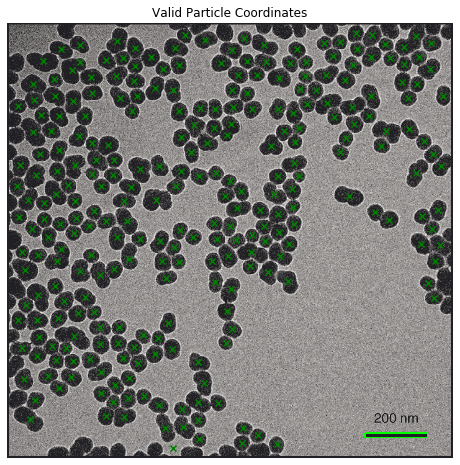

In [13]:
valid_coords = data.valid_coords

plt.figure(figsize=(8, 8))
plt.title('Valid Particle Coordinates')
plt.imshow(image)
plt.scatter(valid_coords[:, 1], valid_coords[:, 0], marker='x', color='green')
plt.axis('off')
plt.show()

#### Radial Distribution Function

#### Method 1: Using imagedataextractor

We can compute the radial distribution function using the `compute_rdf()` method of the `EMData` object.

In [14]:
dr = 5  # set our step size to 5 nm
g_r, radii = data.compute_rdf(dr=dr)

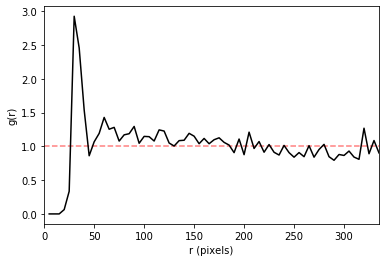

In [15]:
# visualize RDF

plt.plot(radii, g_r, color='k')
plt.hlines(1.0, 0.0, radii.max(), color='r', linestyle='--', alpha=0.5)
plt.xlim(0.0, radii.max())
plt.xlabel('r (pixels)')
plt.ylabel('g(r)')
plt.show()

#### Method 2: Using rdfpy

In [16]:
from imagedataextractor.analysis import rdf2d

# Let's use our scalebar conversion to convert to nanometers.
valid_coords = valid_coords / conversion  # to meters
valid_coords = valid_coords * 1e-9  # to nanometers

dr = 2.5  # nm

g_r, radii = rdf2d(valid_coords, dr=dr)

This method is more flexible, as we can convert the coords to nanometers if we wish. We should obtain the same result as before.

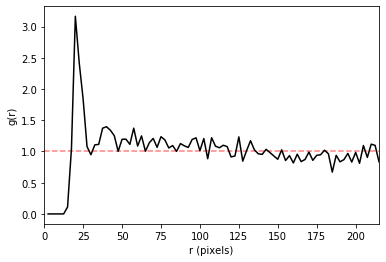

In [17]:
# visualize RDF

plt.plot(radii, g_r, color='k')
plt.hlines(1.0, 0.0, radii.max(), color='r', linestyle='--', alpha=0.5)
plt.xlim(0.0, radii.max())
plt.xlabel('r (pixels)')
plt.ylabel('g(r)')
plt.show()